In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOVICAT2 as HALOVICAT
from complementary_models import HALOVAECAT2 as HALOVAECAT
import scanpy as sc
import scvi
import pandas as pd
torch.autograd.set_detect_anomaly(True) 


Global seed set to 0


In [2]:
## load the data
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)


In [3]:
## Merge Data
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'time_key']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
adata_mvi.obs

,celltype,batch_id,modality,time_key
AAACAGCCAACCGCCA-1_paired,Upper Layer,1,paired,12
AAACAGCCAAGGTCGA-1_paired,"RG, Astro, OPC",1,paired,5
AAACAGCCAGGAACAT-1_paired,Deeper Layer,1,paired,17
AAACAGCCATATTGAC-1_paired,Deeper Layer,1,paired,19
AAACAGCCATGGTTAT-1_paired,Subplate,1,paired,10
...,...,...,...,...
TTTGTGGCATAATCGT-1_paired,Ependymal cells,1,paired,9
TTTGTGGCATTTGCTC-1_paired,Upper Layer,1,paired,11
TTTGTGTTCAATGACC-1_paired,IPC,1,paired,5
TTTGTTGGTGGAGCAA-1_paired,Deeper Layer,1,paired,15


In [4]:
HALOVICAT.setup_anndata(adata_mvi, batch_key="modality", time_key='time_key')
mvi_p = HALOVICAT(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    alpha=0.02,
    beta_1=512,
    beta_2=512,
    beta_3=512,
    n_latent_dep=15,
    n_latent_indep=5
)

time key in registry : True
cell type key in registry: False


In [5]:
mvi_p.train(use_gpu=True, batch_size=512, max_epochs=300)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


independent distance ATAC-RNA -1.4196028859957133e-05
recon_loss 140648.3125, kl_divergence 0.0
independent distance ATAC-RNA -1.4196028859957133e-05, nod_loss 85784373.41839792
independent distance ATAC-RNA 1.7927118272503817e-07
recon_loss 130922.8125, kl_divergence 0.0
independent distance ATAC-RNA 1.7927118272503817e-07, nod_loss 100158737.72342712
independent distance ATAC-RNA -1.6500938864946746e-06
recon_loss 119535.546875, kl_divergence 0.0
independent distance ATAC-RNA -1.6500938864946746e-06, nod_loss 98329225.63039282
independent distance ATAC-RNA 1.3071597304006519e-05
recon_loss 102989.171875, kl_divergence 0.0
independent distance ATAC-RNA 1.3071597304006519e-05, nod_loss 113050773.68183747
independent distance ATAC-RNA 7.82922157214691e-07
recon_loss 93994.8203125, kl_divergence 0.0
independent distance ATAC-RNA 7.82922157214691e-07, nod_loss 100761948.73474316
independent distance ATAC-RNA -6.172506997413271e-06
recon_loss 91333.8203125, kl_divergence 0.0
independent di

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [18]:
mvi_p.save("./cat_models/model_reverse")

In [12]:
## load models of HALO
mvi_p = mvi_p.load("./cat_models/alpha001beta1000_100epoch", adata=adata_mvi)
# mvi_p.beta_1=1e5
# mvi_p.beta_2=1e5
# mvi_p.beta_3=1e6

INFO     File ./cat_models/alpha001beta1000_100epoch/model.pt already downloaded             


RuntimeError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 10.73 GiB total capacity; 7.68 GiB already allocated; 180.88 MiB free; 8.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
mvi_p.train(use_gpu=True, batch_size=512, max_epochs=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


torch.Size([512, 20]) torch.Size([512, 20])
coupled  ATAC->RNA 0.010642752655734057, RNA->ATAC 0.010642759766854689
Lagging ATAC->RNA score 0.010637698102114141, RNA->ATAC 0.010639070591807563
a2rscore_coupled_loss: 3.572473442659428 , r2ascore_coupled_loss: 3.572402331453112 /n a2rscore_lagging_loss: 7.376981021141408,  a2r_r2a_score_loss: 0.9862751030657756
independent distance ATAC-RNA -1.372489693422449e-06
torch.Size([512, 20]) torch.Size([512, 20])
coupled  ATAC->RNA 0.010296096265757875, RNA->ATAC 0.010296127033864462
Lagging ATAC->RNA score 0.010293073520427059, RNA->ATAC 0.010296591956954735
a2rscore_coupled_loss: 7.039037342421251 , r2ascore_coupled_loss: 7.038729661355382 /n a2rscore_lagging_loss: 3.9307352042705865,  a2r_r2a_score_loss: 0.9648156347232392
independent distance ATAC-RNA -3.518436527676083e-06
torch.Size([512, 20]) torch.Size([512, 20])
coupled  ATAC->RNA 0.009599779747250849, RNA->ATAC 0.009599765765868566
Lagging ATAC->RNA score 0.009599719916619391, RNA->AT

In [6]:

latent_atac, latent_expr, latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times = mvi_p.get_latent_representation()

In [7]:
from complementary_models.infer_nonsta_dir import infer_nonsta_dir

score1, _, _ = infer_nonsta_dir(latent_atac_dep, latent_expr_dep, times)
score1

0.009233136337018732

In [8]:
score2, _, _= infer_nonsta_dir(latent_expr_dep, latent_atac_dep, times)
score2

0.009122156577503707

In [9]:
score3, _, _ = infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score3

0.009854740948411806

In [10]:
score4, _, _ = infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
score4

0.009120431829120576

In [11]:
score3 - score4

0.0005887657371839751

In [12]:
from numpy.linalg import inv
import pandas as pd

X = latent_atac
Y =  latent_expr

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)

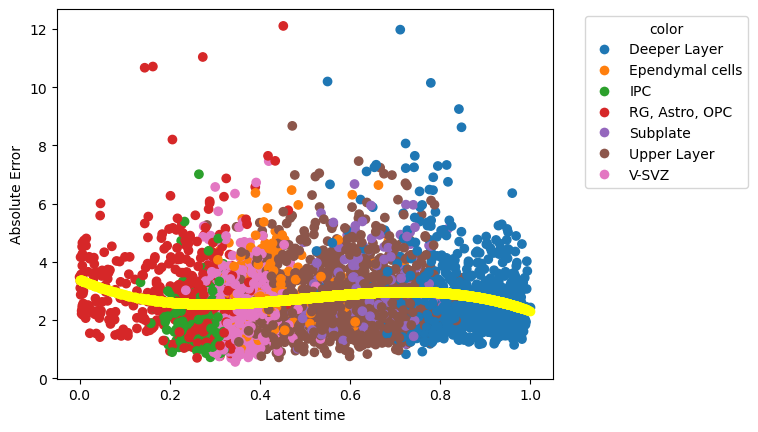

In [13]:
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

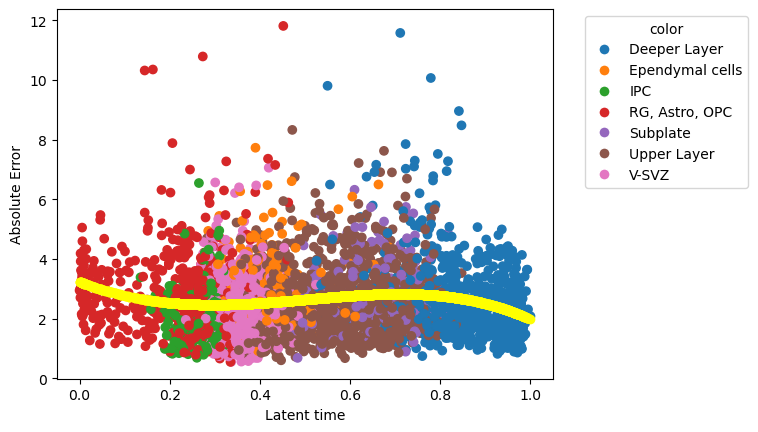

In [14]:
X = latent_atac_dep
Y =  latent_expr_dep


b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

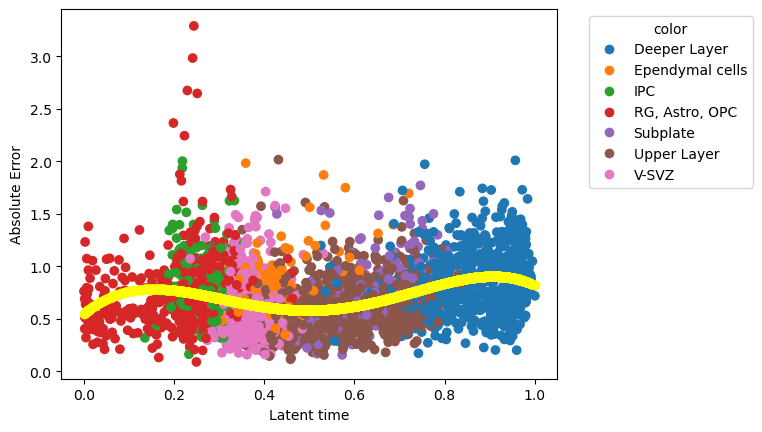

In [16]:
X = latent_atac_indep
Y =  latent_expr_indep


b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()